# IOOS Environment

### Read WFS data from USGS ScienceBase into Shapely/Cartopy

Read shapefile data from USGS ScienceBase WFS 1.1 service in JSON format.

(shapefile was previosly uploaded to ScienceBase, creating the WFS service)

```
getCapabilities

https://www.sciencebase.gov/catalogMaps/mapping/ows/5342c54be4b0aa151574a8dc?service=wfs&version=1.0.0&request=GetCapabilities

containes LatLongBoundingBox for each feature
```

Some USGS ScienceBase Geoserver WFS endpoints:
- https://www.sciencebase.gov/catalogMaps/mapping/ows/5342c54be4b0aa151574a8dc
- https://www.sciencebase.gov/catalogMaps/mapping/ows/5342c5fce4b0aa151574a8ed
- https://www.sciencebase.gov/catalogMaps/mapping/ows/5342e124e4b0aa151574a969

In [1]:
from owslib.wfs import WebFeatureService


endpoint = 'https://www.sciencebase.gov/catalogMaps/mapping/ows/5342c5fce4b0aa151574a8ed'
wfs = WebFeatureService(endpoint, version='1.1.0')

print(wfs.version)

1.1.0


In [2]:
shp = wfs.contents.keys()

print(shp)

['sb:footprint', 'sb:Conservation_Zone_WGS84']


In [3]:
a = wfs.contents['sb:footprint']

b = a.boundingBoxWGS84

In [4]:
shp = filter(lambda a: a != 'sb:footprint', shp)

print(shp)

['sb:Conservation_Zone_WGS84']


In [5]:
import numpy as np


def flip_geojson_coordinates(geo):
    if isinstance(geo, dict):
        for k, v in geo.iteritems():
            if k == "coordinates":
                z = np.asarray(geo[k])
                f = z.flatten()
                geo[k] = np.dstack((f[1::2], f[::2])).reshape(z.shape).tolist()
            else:
                flip_geojson_coordinates(v)
    elif isinstance(geo, list):
        for k in geo:
            flip_geojson_coordinates(k)

In [6]:
import geojson

# srs='EPSG:4326' # v1.0 syntax
srs = 'urn:x-ogc:def:crs:EPSG:4326'  # v1.1 syntax

json_response = wfs.getfeature(typename=[shp[0]], propertyname=None,
                               srsname=srs, outputFormat='application/json').read()
geo = geojson.loads(json_response)
flip_geojson_coordinates(geo)

In [7]:
print(geo.keys())

[u'crs', u'type', 'features']


In [8]:
print(geo['type'])

FeatureCollection


/home/filipe/miniconda/envs/IOOS/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


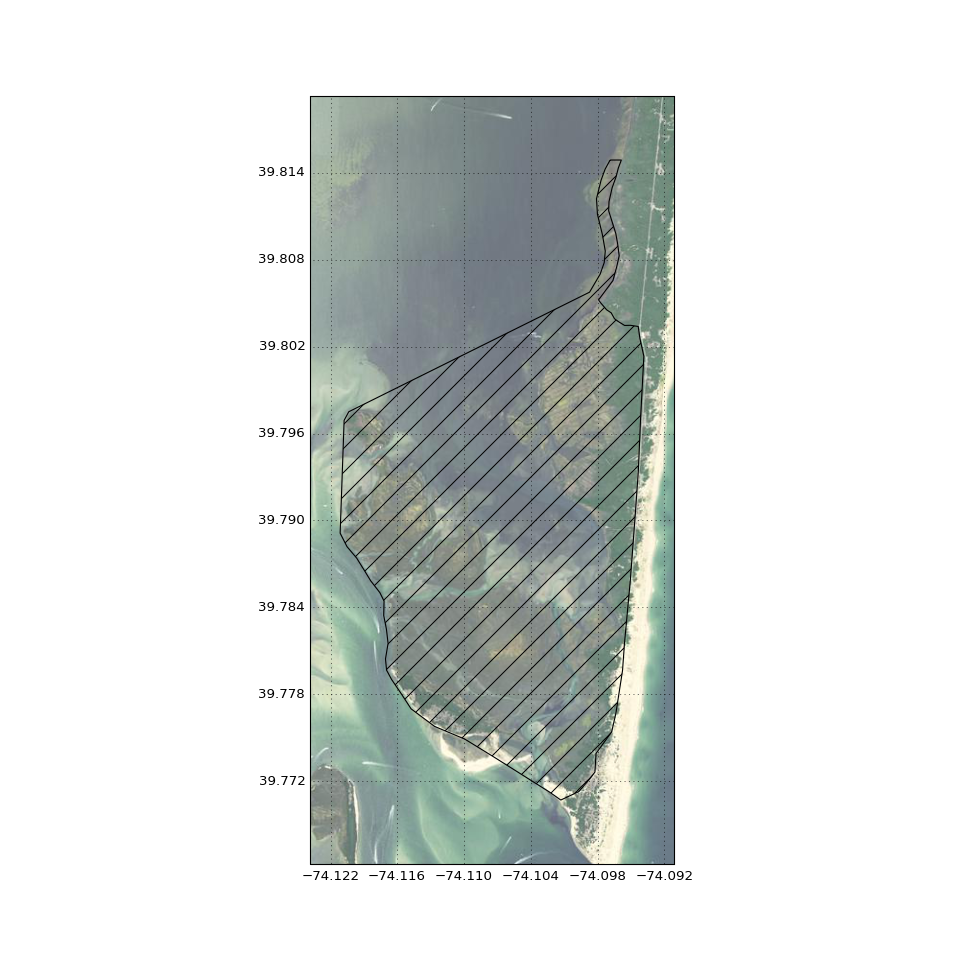

bounds from Shapely: (-74.12113865030754, 39.77069522703161, -74.09384984325125, 39.81488113835475)


In [9]:
%matplotlib notebook

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from shapely.geometry import asShape, shape
from cartopy.io.img_tiles import MapQuestOpenAerial

geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

plt.figure(figsize=(12,12))
tiler = MapQuestOpenAerial()
ax = plt.axes(projection=tiler.crs)
dx = b[2]-b[0]
dy = b[3]-b[1]
extent = (b[0]-0.1*dx, b[2]+0.1*dx, b[1]-0.1*dy, b[3]+0.1*dy)
ax.set_extent(extent, geodetic)
ax.add_image(tiler, 14)

for p in geo.get("features", []):
    multi_poly = asShape(p.get("geometry"))
    print('bounds from Shapely: {}'.format(multi_poly.bounds))
    ax.add_geometries(multi_poly,ccrs.PlateCarree(),
                      edgecolor='black',facecolor='none',hatch='/')
    
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False